In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

import featuretools as ft

import utils

import lightgbm as lgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import time

import optuna

In [2]:
data_dir = '../data/'
filenames = os.listdir(data_dir)
for i, ele in enumerate(filenames):
    print(i, ele)

0 olist_customers_dataset.csv
1 olist_geolocation_dataset.csv
2 olist_orders_dataset.csv
3 olist_order_items_dataset.csv
4 olist_order_payments_dataset.csv
5 olist_order_reviews_dataset.csv
6 olist_products_dataset.csv
7 olist_sellers_dataset.csv
8 processed
9 product_category_name_translation.csv


In [3]:
df_customers = pd.read_csv(data_dir+filenames[0])
df_orders = pd.read_csv(data_dir+filenames[2], parse_dates=['order_purchase_timestamp',
                                                            'order_approved_at', 
                                                            'order_delivered_carrier_date',
                                                            'order_delivered_customer_date',
                                                            'order_estimated_delivery_date'])

df_items = pd.read_csv(data_dir+filenames[3], parse_dates=['shipping_limit_date'])
# df_payments = pd.read_csv(data_dir+filenames[4])
df_payments = utils.read_pickles('../data/processed/payments')

100%|██████████| 3/3 [00:00<00:00, 52.64it/s]


In [4]:
df_payments['payment_type_mode'] = df_payments['payment_type_mode'].astype('category').cat.codes.values
df_orders['order_status'] = df_orders['order_status'].astype('category').cat.codes.values

In [5]:
target = df_payments.pop('payment_value')

In [6]:
# Create entityset
entity_set = ft.EntitySet(id = 'order_val')

# order entity
entity_set = entity_set.entity_from_dataframe(
    entity_id='orders',
    dataframe=df_orders,
    index='order_id',
    variable_types = {'order_status': ft.variable_types.Categorical}
)

# item entity
entity_set = entity_set.entity_from_dataframe(
    entity_id='items',
    dataframe=df_items,
    make_index=True,
    index = 'item_id',
    time_index = 'shipping_limit_date'
)

# payments entity
entity_set = entity_set.entity_from_dataframe(
    entity_id='payments',
    dataframe=df_payments,
    index='order_id',
    variable_types = {'payment_type_mode': ft.variable_types.Categorical}
)

entity_set

Entityset: order_val
  Entities:
    orders [Rows: 99441, Columns: 8]
    items [Rows: 112650, Columns: 8]
    payments [Rows: 99440, Columns: 6]
  Relationships:
    No relationships

In [7]:
# Create the relationships (parents-->child) (parent have one id child may have multiple parent ids)
relationship_payments_orders = ft.Relationship(entity_set['orders']['order_id'],
                                               entity_set['payments']['order_id'])

relationship_items_orders = ft.Relationship(entity_set['orders']['order_id'],
                                            entity_set['items']['order_id'])


# Add the relationships to the entity set
entity_set = entity_set.add_relationship(relationship_payments_orders)
entity_set = entity_set.add_relationship(relationship_items_orders)

# Check entity_set
entity_set

Entityset: order_val
  Entities:
    orders [Rows: 99441, Columns: 8]
    items [Rows: 112650, Columns: 8]
    payments [Rows: 99440, Columns: 6]
  Relationships:
    payments.order_id -> orders.order_id
    items.order_id -> orders.order_id

In [9]:
transformation_feats = [ 'year', 'month', 'weekday', 'subtract']
aggregate_feats = ['mean', 'std']

df_features, feature_names = ft.dfs(entityset = entity_set,
                                      target_entity = "payments",
                                      trans_primitives = transformation_feats,
                                      agg_primitives = aggregate_feats,                  
                                      max_depth = 2,
                                      verbose = True)

Built 48 features
Elapsed: 00:07 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


In [10]:
df_customers['customer_city'] = df_customers['customer_city'].astype('category').cat.codes
df_customers['customer_state'] = df_customers['customer_state'].astype('category').cat.codes

In [11]:
# Create entityset
cust_entity_set = ft.EntitySet(id = 'cust_relation')

# customers entity
entity_set = cust_entity_set.entity_from_dataframe(
    entity_id = 'features',
    dataframe = df_features,
    index = 'orders.customer_id'
)
# customers entity
entity_set = cust_entity_set.entity_from_dataframe(
    entity_id = 'customers',
    dataframe = df_customers,
    index = 'customer_id'
)

cust_entity_set

Entityset: cust_relation
  Entities:
    features [Rows: 99440, Columns: 48]
    customers [Rows: 99441, Columns: 5]
  Relationships:
    No relationships

In [12]:
relationship_customer_orders = ft.Relationship(cust_entity_set['features']['orders.customer_id'],
                                               cust_entity_set['customers']['customer_id'])

entity_set = cust_entity_set.add_relationship(relationship_customer_orders)

entity_set

In [13]:
# df_features, feature_names = ft.dfs(entityset = cust_entity_set,
#                                       target_entity = "features",
#                                       trans_primitives = [],
#                                       agg_primitives = ['mean'],                  
#                                       max_depth = 2,
#                                       verbose = True)

Built 50 features
Elapsed: 00:04 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


In [15]:
# df_features.drop('orders.customer_id', axis=1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(df_features, target, test_size=0.33, random_state=42)

In [16]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1}

In [17]:
folds = KFold(n_splits=3, shuffle=True, random_state=15)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
start = time.time()
feature_importance_df = pd.DataFrame()

features = list(x_train.columns)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features], label=y_train.iloc[trn_idx])
#                            , categorical_feature=categorical_feats)
    val_data = lgb.Dataset(x_train.iloc[val_idx][features], label=y_train.iloc[val_idx])
#                            , categorical_feature=categorical_feats)

    num_round = 1000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data],
                    verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, y_train)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 217.142	valid_1's rmse: 241.119
[200]	training's rmse: 216.283	valid_1's rmse: 241.195
Early stopping, best iteration is:
[1]	training's rmse: 218.163	valid_1's rmse: 241.061
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 229.053	valid_1's rmse: 217.841
[200]	training's rmse: 228.208	valid_1's rmse: 217.866
[300]	training's rmse: 227.414	valid_1's rmse: 217.898
Early stopping, best iteration is:
[123]	training's rmse: 228.842	valid_1's rmse: 217.838
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 228.766	valid_1's rmse: 218.501
[200]	training's rmse: 227.903	valid_1's rmse: 218.52
Early stopping, best iteration is:
[53]	training's rmse: 229.22	valid_1's rmse: 218.481
CV score: 226.05134


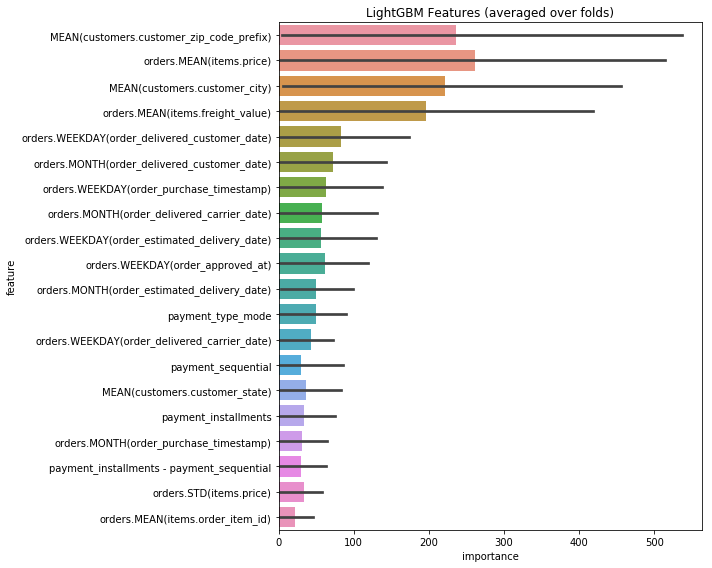

In [18]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,8))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.show()